# Elo Loyalty Prediction

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Contents
- [Introduction](#introduction)
    * [Problem Statement](#problem-statement)
- [Exploratory Data Analysis](#eda)
- [Feature Engineering](#feature-engineering)
- [Model Building](#model-building)
    * [Linear Regression](#linear-regression)
    * [Gradient Bososted Tree](#gradient-boosted-trees)
- [Model Analysis](#model-analysis)
- [Conclusion](#conclusion)



## Introduction<a class="anchor" id="introduction"></a>


Elo, one of Brazil's largest payment brands, is partnered with many merchants to offer promotions and discounts to their cardholders. Elo aimed to reduce marketting that is irrelevant to members and offer them custom-tailored promotions, thereby providing an enjoyable experience and beneficial service. To that end, Elo launched a Kaggle competition, enlisting the Kaggle community's help, to produce a machine learning model that can find signal between trasaction data and loyalty. Such a model will help Elo gauge customer loyalty and how promotional strategies affect it.

**The data provided is simulated and fictitious. It does not contain real customer data.*


### Problem Statement<a class="anchor" id="problem-statement"></a>
Build a machine learning model that can effectively predict customer loyalty scores using trasaction data.

## Exploratory Data Analysis <a class="anchor" id="eda"></a>

The data contained five main tables consisting **train data**, **test data**, **historical transactions**, **new merchant transactions** and **merchants**.

**train data** table contained card_ids, loyalty scores and 3 arbitrary features provided by ELO. The aribtrary features were not very useful as they did not provide much signal in predicting loyalty scores.

**test data** table contained the same arbitrary features as **train data** and card_id but did not contain loyalty scores.

**historical transactions** contained details on purchases made by all the cardholders in the dataset. Details included purchase amount, merchant category, etc. Every card_id had atleaset 3 months of records.

**new merchant transactions** contained transaction data from new merchants the cardholder had not yet purchased from in the historical transaction data. Every card_id had upto two months of new merchant data after a reference date (which differed for each card_id).

**merchants** contained details on merchants seen in **historical transactions** and **new merchant transactions**


The data was heavily anonymized. Non-numerical data such as city of purchase and merchant category were reassigned with arbitrary value so it is difficult to connect real world knowledge and find insights.





In [3]:
# load data

# train data
traindf = pd.read_csv('./data/train.csv')

# given test data with no loyaltly score
giventestdf = pd.read_csv('./data/test.csv')
giventestdf['card_id'].nunique()

# historical transaction data
histtransdf = pd.read_csv('./data/historical_transactions.csv')

# new merchant transactional data
newtransdf = pd.read_csv('./data/new_merchant_transactions.csv')

# merchant data
merchdf = pd.read_csv('./data/merchants.csv')

In [4]:
# training dataset at glance
traindf.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [5]:
traindf.card_id.nunique()

201917

In [6]:
histtransdf.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [7]:
histtransdf['card_id'].nunique()

325540

In [8]:
histtransdf.shape

(29112361, 14)

In [9]:
newtransdf.card_id.nunique()

290001

In [10]:
merchdf['merchant_id'].nunique()

334633

There are 201,917 card ids in the training data set.

There are 123,623 card ids in the test data. This data cannot be used to train the model as it does not have loyalty scores (the response variable)

Hisotrical transaction data has 325,540 card ids with 29,112,361 transactions. Train and test card ids are both included in this historical data.

New merchant transactional data set had 290,001 card ids.

There were 334,633 different merchants in the merchant data.

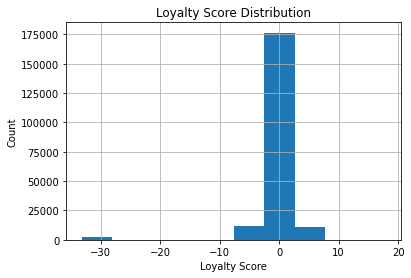

In [11]:
# plotting loyalty score distribution
traindf['target'].hist()
plt.xlabel('Loyalty Score')
plt.ylabel('Count')
plt.title('Loyalty Score Distribution');

Loyalty scores are normally distriubted ranging from -10 to 10. There are some outliers at -33.

## Feature Engineering<a class='anchor' id='feature-engineering'></a>

#### Features to Engineer <br>
*features are engineered to cardholder level* <br><br>
`tof` - (Time on File) Number of days between first and last purchase date of cardholder.<br><br>
`recency` - (Recency) Number of days between last date of all transactions and last date of purchase by a cardholder.<br><br>
`frequency` - (Frequency) Total number of transactions by a cardholder.<br><br>
`log_freq` - (Log(Frequency)) Log transformation of frequency may reduce outliers and linearize exponential trait of frequency distribution.<br><br>
`amt` - (Amount) Sum of all purchase amounts.<br><br>
`avg_amt` - (Average Amount) Average amount of all purchases.<br><br>
`charge_per_day` - (Charge per Day) Average number of transactions per day for cardholders time on file.<br><br>
`log_charge_per_day` - (Log(Charge per Day)) Log transform of charge per day. Linearizes exponential trait of charge_per_day.<br><br>
`max_amt` - (Max Purchase Amt) Highest purchase amount of a cardholder.<br><br>
`n_declines` - (Number of Declines) Number of times card was declined for a puchase. Authorized flag was 'N'.<br><br>
`log_n_declines` - (Log(Number of Declines)) Log transform of number of declines. Linearizes exponential trait of number of declines.<br><br>
`prop_new` - (Proportion New) Proportion of new merchant purchases in all purchases.<br><br>
`merch_cat_1_Y` - (Count when Merchant Category 1 is Yes) Sum of all times Anonymized merchant category 1 is yes.<br><br>
`merch_cat_2_x` - (Count when Merchant Category 2 is x) Sum of all times Anonymized merchant category 2 is x, where x can be values between 1-5.

In [30]:
# concatenating all transaction data and adding indicator of new merchant
histtransdf['new'] = False
newtransdf['new'] = True
alltransdf = pd.concat([histtransdf, newtransdf])

In [31]:
alltransdf['purchase_date'] = pd.to_datetime(alltransdf['purchase_date'])
alltransdf['authorized_flag'] = alltransdf.authorized_flag.apply(lambda x: True if x=='Y' else False)
alltransdf['city_id'] = alltransdf.city_id.apply(str)


In [34]:
last_day = alltransdf.purchase_date.max() # last day recorded in all of transactions
groups = alltransdf.groupby('card_id')

def safe_log(x):
    # log function to prevent getting log of zero
    if x <= 0:
        return 0
    else:
        return np.log(x)
    
# aggregating transactional data and features at card_id/cardholder level
cardholdersdf = pd.DataFrame()
cardholdersdf['tof'] = (last_day - groups.purchase_date.min()).apply(lambda x: x.days)
cardholdersdf['recency'] = (last_day - groups.purchase_date.max()).apply(lambda x: x.days)
cardholdersdf['frequency'] = groups.size()
cardholdersdf['log_freq'] = cardholdersdf.frequency.apply(np.log)
cardholdersdf['amt'] = groups.purchase_amount.sum()
cardholdersdf['avg_amt'] = cardholdersdf['amt'] / cardholdersdf['frequency']
cardholdersdf['charge_per_day'] = cardholdersdf['frequency'] / (cardholdersdf['tof'] + 1)
cardholdersdf['log_charge_per_day'] = cardholdersdf['charge_per_day'].apply(np.log)
cardholdersdf['max_amt'] = groups.purchase_amount.max()
cardholdersdf['n_declines'] = groups.size() - groups.authorized_flag.sum()
cardholdersdf['log_n_declines'] = cardholdersdf['n_declines'].apply(safe_log)
cardholdersdf['prop_new'] = groups.new.sum() / groups.size()
cardholdersdf['merch_cat_1_Y'] = groups.apply(lambda x: (x['category_1']=='Y').sum())
cardholdersdf['merch_cat_2_1'] = groups.apply(lambda x: (x['category_2']==1).sum())
cardholdersdf['merch_cat_2_2'] = groups.apply(lambda x: (x['category_2']==2).sum())
cardholdersdf['merch_cat_2_3'] = groups.apply(lambda x: (x['category_2']==3).sum())
cardholdersdf['merch_cat_2_4'] = groups.apply(lambda x: (x['category_2']==4).sum())
cardholdersdf['merch_cat_2_5'] = groups.apply(lambda x: (x['category_2']==5).sum())

In [40]:
new_train = traindf.join(cardholdersdf, how='left', on='card_id')
new_test = giventestdf.join(cardholdersdf, how='left', on='card_id')

In [47]:
X_new_train = new_train.drop(columns=['target'])
y_new_train = new_train['target']


## Model Building<a class='anchor' id='model-building'></a>

### Linear Regression <a class='anchor' id='linear-regression'></a>

### Gradient Boosted Trees <a class="anchor" id='gradient-boosted-trees'></a>

## Conclusion <a class='anchor' id='conclusion'></a>